# Time series predictions of global economic indicators using the IMF World Economic Overview dataset
## By Quinn Murphey
### UTSA Mathematics Department

# Libraries

- Data processing and manipulation: NumPy and Pandas
- Graphics: Matplotlib Pyplot
- Modelling: Tensorflow

In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Data

All data used is publicly availiable at https://www.imf.org/en/Publications/WEO/weo-database/2021/October/download-entire-database.

There were some minor changes to the database to help convert from .xls to .csv.

In [2]:
rawData = pd.read_csv("WEOOct2021all.csv")
rawData

,WEO Country Code,ISO,WEO Subject Code,Country,Subject Descriptor,Subject Notes,Units,Scale,Country/Series-specific Notes,1980,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,Estimates Start After
0,512,AFG,NGDP_R,Afghanistan,"Gross domestic product, constant prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,270.22","1,319.90","1,288.87",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
1,512,AFG,NGDP_RPCH,Afghanistan,"Gross domestic product, constant prices",Annual percentages of constant price GDP are y...,Percent change,NaN,"See notes for: Gross domestic product, consta...",NaN,...,1.189,3.912,-2.351,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
2,512,AFG,NGDP,Afghanistan,"Gross domestic product, current prices",Expressed in billions of national currency uni...,National currency,Billions,Source: National Statistics Office Latest actu...,NaN,...,"1,327.69","1,469.60","1,547.29",NaN,NaN,NaN,NaN,NaN,NaN,2019.0
3,512,AFG,NGDPD,Afghanistan,"Gross domestic product, current prices",Values are based upon GDP in national currency...,U.S. dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,18.401,18.876,20.136,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
4,512,AFG,PPPGDP,Afghanistan,"Gross domestic product, current prices",These data form the basis for the country weig...,Purchasing power parity; international dollars,Billions,"See notes for: Gross domestic product, curren...",NaN,...,77.406,81.873,80.912,NaN,NaN,NaN,NaN,NaN,NaN,2019.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,698,ZWE,GGXWDG,Zimbabwe,General government gross debt,Gross debt consists of all liabilities that re...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,14.459,181.867,968.863,"1,187.21","1,615.81","1,924.61","2,169.96","2,357.23","2,518.86",2019.0
8816,698,ZWE,GGXWDG_NGDP,Zimbabwe,General government gross debt,Gross debt consists of all liabilities that re...,Percent of GDP,NaN,See notes for: General government gross debt ...,NaN,...,61.486,113.923,86.147,54.013,60.311,62.027,62.24,60.688,59.609,2019.0
8817,698,ZWE,NGDP_FY,Zimbabwe,Gross domestic product corresponding to fiscal...,Gross domestic product corresponding to fiscal...,National currency,Billions,Source: Ministry of Finance or Treasury Latest...,NaN,...,23.516,159.641,"1,124.67","2,198.00","2,679.15","3,102.88","3,486.45","3,884.16","4,225.61",2019.0
8818,698,ZWE,BCA,Zimbabwe,Current account balance,Current account is all transactions other than...,U.S. dollars,Billions,Source: Reserve Bank of Zimbabwe and Ministry ...,-0.301,...,-1.38,0.92,1.275,1.262,1.06,0.621,0.148,-0.247,-0.683,2019.0


## Database Description
The database used is a semi-annual publication by the International Monetary Fund tracking 44 various economic indicators for 194 countries from 1980 to 2020. One important note, is that the database is not full, meaning that we will have to carefully deal with NaN entries in our preprocessing. As a whole, our database has 8820 rows and 57 columns.

### Columns
- WEO Country Code: Integer code representing the country
- ISO: 3 character code representing the country
- WEO Subject Code: String representing a specific indicator
- Country: Full name of country
- Subject Descriptor: Definition of respective WEO Subject Code
- Subject Notes: Further explanation of WEO Subject Code
- Units: Unit of measurement of indicator
- Scale: Scale of indicator
- Country/Series-specific Notes: Indicator notes describing source + misc for country
- 1980-2026: Float holding data for each year corresponding to the Country and WEO Subject Code
- Estimates Start After: The last year of non predicted data

### Countries

In [3]:
print(rawData[~rawData['Country'].isna()]["Country"].unique())

['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'The Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Democratic Republic of the Congo' 'Republic of Congo' 'Costa Rica'
 'Croatia' 'Cyprus' 'Czech Republic' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji' 'Finland' 'France'
 'Gabon' 'The Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hong Kong SAR' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Islamic Republic of Iran' 'Iraq' 'Ireland' 'Israel' 'Italy

### WEO Country Codes

For the rest of the report, we will refer to each indicator by its WEO Subject Code, and for assistance, we will create a dict entry for each code to its description and units and scale. Here are our 44 codes and their descriptions.

In [4]:
# Compile dict of WEO Subject Code to description
codesDict = {}
codes = rawData[["WEO Subject Code","Subject Descriptor","Units", "Scale"]]
for weocode in pd.unique(codes["WEO Subject Code"])[:-1]:
    codesDict[weocode] = codes[codes.values == weocode]['Subject Descriptor'].iloc[0] + \
        " (" + codes[codes.values == weocode]['Units'].iloc[0] + "; " + str(codes[codes.values == weocode]['Scale'].iloc[0]) + ")"

codesDict

{'NGDP_R': 'Gross domestic product, constant prices (National currency; Billions)',
 'NGDP_RPCH': 'Gross domestic product, constant prices (Percent change; nan)',
 'NGDP': 'Gross domestic product, current prices (National currency; Billions)',
 'NGDPD': 'Gross domestic product, current prices (U.S. dollars; Billions)',
 'PPPGDP': 'Gross domestic product, current prices (Purchasing power parity; international dollars; Billions)',
 'NGDP_D': 'Gross domestic product, deflator (Index; nan)',
 'NGDPRPC': 'Gross domestic product per capita, constant prices (National currency; Units)',
 'NGDPRPPPPC': 'Gross domestic product per capita, constant prices (Purchasing power parity; 2017 international dollar; Units)',
 'NGDPPC': 'Gross domestic product per capita, current prices (National currency; Units)',
 'NGDPDPC': 'Gross domestic product per capita, current prices (U.S. dollars; Units)',
 'PPPPC': 'Gross domestic product per capita, current prices (Purchasing power parity; international dollar

## Database preprocessing

In [5]:
# Constants for easier use later
startYear = 1980
endYear = 2026 

# Create fresh copy of data
data = rawData.copy()

Remove any rows with a 'nan' entry for the Country column 

In [6]:
data = data[~data['Country'].isna()]

We are going to remove all columns from the dataframe other than the following:
- WEO Subject Code
- Country
- 1980-2026
- Estimates Start After (will be removed later)

In [7]:
data = data.drop(columns=["WEO Country Code", "ISO", "Subject Descriptor", "Subject Notes", 
                          "Units", "Scale", "Country/Series-specific Notes"])

In [8]:
# Get unique values of Country and WEO Subject Codes
countries = data["Country"].unique()
codes = list(codesDict.keys())

Next, we will remove all the predicted data contained in the database.

To do this, we find where the estimates start for each country, store it in a dict, and fill the columns from there to 2026 with NaN. After this, we don't need the Estimates Start After column because we have our new dict.

In [9]:
# Find where the estimates start for each country
estimatesStartAfter = {}
for country in countries:
    estimatesStartAfter[country] = np.int_(data.loc[rawData["Country"] == country]["Estimates Start After"].min())
    
# Remove predicted data
for country in countries:
    for year in range(estimatesStartAfter[country] + 1, endYear + 1):
        data.loc[data["Country"] == country, str(year)] = np.nan

# Remove Estimates start after column
data = data.drop(columns="Estimates Start After")

Next, we will remove any full columns from 1980-2026 that do not contain any data.

In [10]:
# Remove any columns with all NaN
numRows = len(data)
dropColumns = []
for column in range(startYear, endYear + 1):
    if data[str(column)].isna().sum() == numRows:
        dropColumns.append(str(column))
data = data.drop(columns=dropColumns)
endYear -= len(dropColumns)

Finally, we will correct the typing of our data.

In [11]:
# Turn float data into float64 dtype
yearColumns = [str(x) for x in range(startYear, endYear + 1)]
data[yearColumns] = data[yearColumns].replace(',','', regex=True)
data[yearColumns] = data[yearColumns].replace('(-)+','', regex=True)
data[yearColumns] = data[yearColumns].replace(r'^\s*$', np.nan, regex=True)
data[yearColumns] = data[yearColumns].astype('float64')

In [12]:
data

,WEO Subject Code,Country,1980,1981,1982,1983,1984,1985,1986,1987,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,NGDP_R,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,958.266,1092.120,1154.180,1185.310,1197.010,1222.920,1255.290,1270.220,1319.900,NaN
1,NGDP_RPCH,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.479,13.968,5.683,2.697,0.988,2.164,2.647,1.189,3.912,NaN
2,NGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,836.222,1033.590,1116.830,1183.040,1226.570,1222.920,1285.460,1327.690,1469.600,NaN
3,NGDPD,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.890,20.293,20.170,20.616,20.057,18.020,18.883,18.401,18.876,NaN
4,PPPGDP,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.334,59.945,63.784,69.444,72.056,70.098,74.712,77.406,81.873,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8815,GGXWDG,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.044,6.549,7.053,8.230,9.477,10.089,11.998,NaN,NaN,NaN
8816,GGXWDG_NGDP,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42.858,38.265,36.944,42.211,47.473,49.096,54.433,NaN,NaN,NaN
8817,NGDP_FY,Zimbabwe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.102,17.115,19.091,19.496,19.963,20.549,22.041,NaN,NaN,NaN
8818,BCA,Zimbabwe,0.301,0.674,0.748,0.504,0.171,0.153,0.051,0.0,...,2.750,2.278,2.649,2.334,1.597,0.697,0.271,NaN,NaN,NaN


## Data Plotting

First we will define our ```plot``` function that we will use throughout the report to help us visualize our data and predictions.

In [13]:
def plot(data, inputWidth=0, labelWidth=0, predictions=None, countries=None, codes=None, startYear=startYear, endYear=endYear):
    fig = plt.figure(figsize=(12, 12))
    yearColumnsStr = [str(x) for x in range(startYear, endYear + 1)]
    yearColumnsInt = [x for x in range(startYear, endYear + 1)]
    
    # Loop over Countries, Code
    subfigs = fig.subfigures(nrows=max(len(countries),2), ncols=1)
    i = 1
    for subfig, country in zip(subfigs,countries):
        subfig.suptitle(country)
        for col, code in enumerate(codes,start=1):
            # Create subplot and set values
            ax = fig.add_subplot(len(countries),len(codes),i)
            ax.set_title(' ')
            i += 1
            plt.ylabel(f'{code}')
            plt.xlabel("Year")

            # Plot inputs
            plt.plot(yearColumnsInt, 
                    data[(data["Country"] == country) & (data["WEO Subject Code"] == code)][yearColumns].values[0], 
                    label='Inputs', marker='.', zorder=-10)

            # Plot labels
            if inputWidth != 0 and labelWidth != 0:
                plt.scatter(yearColumnsInt[inputWidth:], 
                        data[(data["Country"] == country) & (data["WEO Subject Code"] == code)][yearColumns[inputWidth:]].values[0], 
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            # Plot predictions
            if predictions is not None:
                if labelWidth == 1:
                    plt.scatter(yearColumnsInt[inputWidth:], 
                                predictions,
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)
                else:
                    for i in range(len(predictions)):
                        if i == 0:
                            plt.plot(yearColumnsInt[inputWidth + i :inputWidth + labelWidth + i], 
                                    predictions[i],
                                    marker='X', label='Predictions',
                                    c='#ff7f0e')
                        else:
                            plt.plot(yearColumnsInt[inputWidth + i :inputWidth + labelWidth + i], 
                                    predictions[i],
                                    marker='X',
                                    c='#ff7f0e')
            
            plt.legend()
    
    plt.tight_layout(h_pad=2)
    plt.show()
    


For example, we can print the GDP (PPP) and GDP per capita (PPP) for the United States and the United Kingdom

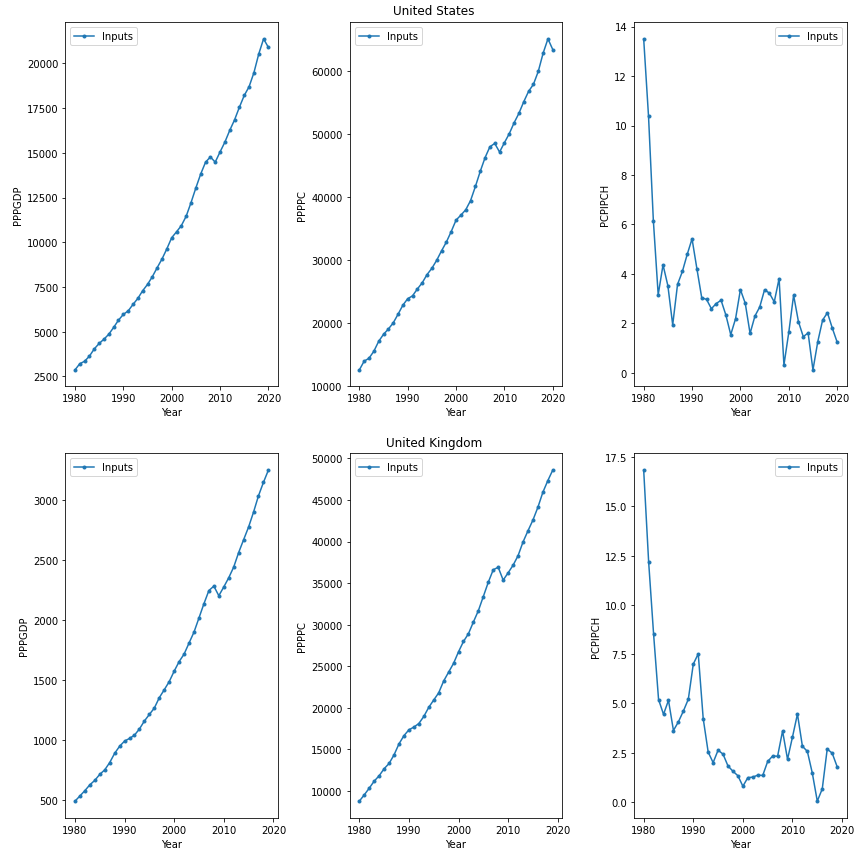

In [14]:
plot(data,countries=["United States", "United Kingdom"],codes=["PPPGDP", "PPPPC","PCPIPCH"])

In [15]:
def data_subset(data, countries, codes):
    return data[(data["Country"].isin(countries)) & (data["WEO Subject Code"].isin(codes))]

In [16]:
def normalize(data):
    normalized_data = data.copy()
        
    codes = data["WEO Subject Code"].unique()
    
    yearColumns = data.columns[2:]
    
    for code in codes:
        mean = data[data["WEO Subject Code"] == code][yearColumns].stack().mean()
        std = data[data["WEO Subject Code"] == code][yearColumns].stack().std()
        
        normalized_data.loc[normalized_data["WEO Subject Code"] == code, yearColumns] = \
                data.loc[normalized_data["WEO Subject Code"] == code,yearColumns].applymap(
                    lambda x : (x - mean) / std)    
    return normalized_data

In [17]:
def data_to_time_series(data, width, startYear, endYear):
    
    countries = data["Country"].unique()
    codes = data["WEO Subject Code"].unique()

    columns = ["Country", "End Year"]
    for code in codes:
        for year in range(width):
            columns.append(code + "-" + str(year))
    
    numRows = len(countries) * ((endYear - startYear) - width + 2)
    numCols = len(columns)
    
    time_series = pd.DataFrame(data=np.empty((numRows, len(columns))),columns=columns)
    
    index = 0
    for country in countries:
        for endYear in range(startYear + width - 1, endYear + 1):
            newRow = np.empty(numCols, dtype=np.object)
            newRow[0:2] = [country,endYear]
            
            yearColumns = [str(x) for x in range(endYear - width + 1, endYear + 1)]
            startSlice = 2
            endSlice = startSlice + width
            for code in codes:
                test = data[(data["Country"] == country) & (data["WEO Subject Code"] == code)][yearColumns]
                if test.shape == (1, width):
                    newRow[startSlice:endSlice] = test
                startSlice += width
                endSlice += width            
            time_series.iloc[index] = newRow
            index += 1
    
    time_series["Country"] = time_series["Country"].astype(str)
    time_series["End Year"] = time_series["End Year"].astype("int64")
                
    return time_series

In [18]:
def feature_label_split_time_series(timeSeries, featureWidth=9, labelWidth=1, 
                                    featureParams=None, labelParams=None):    
    # Determine which columns of the timeSeries are features and which are labels
    featureColumns = []
    for code in featureParams:
        for year in range(featureWidth):
            featureColumns.append(code + '-' + str(year))
    
    labelColumns = []
    for code in labelParams:
        for year in range(featureWidth, featureWidth + labelWidth):
            labelColumns.append(code + '-' + str(year))
    
    timeSeriesTrimmed = timeSeries[featureColumns + labelColumns].dropna()
    
    features = pd.DataFrame(
            data=timeSeriesTrimmed[featureColumns],
            columns=featureColumns)
    
    labels = pd.DataFrame(
            data=timeSeriesTrimmed[labelColumns],
            columns=labelColumns)
    
    return features, labels
    

In [19]:
def time_series_to_tf_dataset(features, labels, featureWidth, labelWidth):
    # Turn each dataframe into their ndarray equivalents
    featureArray = features.values
    labelArray = labels.values
    
    numEntries = len(featureArray)
    
    # Reshape from (Entry, feature/time) -> (Entry, time, feature)
    featureArray = \
            np.array([ 
                [ 
                    [ entry[i * featureWidth + time ] for i in range(len(entry) // featureWidth)]
                for time in range(featureWidth)]
            for entry in featureArray ])
    
    labelArray = \
            np.array([ 
                [ 
                    [ entry[i * labelWidth + time ] for i in range(len(entry) // labelWidth)]
                for time in range(labelWidth)]
            for entry in labelArray ])
    
    featureDataset = tf.data.Dataset.from_tensor_slices(featureArray)
    labelDataset = tf.data.Dataset.from_tensor_slices(labelArray)
    return tf.data.Dataset.zip((featureDataset, labelDataset))

In [20]:
def train_validate_test_split(dataset, trainSplit=0.8, valSplit=0.1, testSplit=0.1, shuffle=True):
    assert (trainSplit + valSplit + testSplit) == 1
    shuffleSize=10000
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        dataset = dataset.shuffle(shuffleSize, seed=0)
    
    dsSize = len(dataset)
    
    trainSize = int(trainSplit * dsSize)
    valSize = int(valSplit * dsSize)
    
    trainDataset = dataset.take(trainSize).repeat(3).batch(1)
    valDataset = dataset.skip(trainSize).take(valSize).repeat(3).batch(1)
    testDataset = dataset.skip(trainSize).skip(valSize).repeat(3).batch(1)
    
    return trainDataset, valDataset, testDataset

## Trim out sparse WEO Subject Codes

We will trim any WEO Subject Codes from our data that have less than 90% of the values that the largest indicator has. This is in order to balance between having a high number of data points and parameters to help us generate a better model.

In [21]:
# Constants
cutoff = .90

countries = data["Country"].unique()
codes = data["WEO Subject Code"].unique()

results = {}
maxS = 0
for code in codes:
    s = 0
    for country in countries:
        s += data[(data["Country"] == country) & (data["WEO Subject Code"] == code)].stack().count() 
    results[code] = s
    if s > maxS:
        maxS = s

usedCodes = []
for code in codes:
    if results[code] >= cutoff * maxS:
        usedCodes.append(code)
data = data_subset(data, data["Country"].unique(), usedCodes)

In [ ]:
usedCodes

## Single parameter input and label
Our preprocessing of our data has several steps.

In [108]:
inputWidth = 9
labelWidth = 1
width = inputWidth + labelWidth
inputParams = ["PPPGDP"]
labelParams = ["PPPGDP"]
trainSplit=0.8
valSplit=0.1
testSplit=0.1
shuffle=True

### Normalize Data
For each WEO Subject Code, we subtract the mean and divide by the std of the data

In [109]:
normalizedData = normalize(data)

### Turn data into a time series
For each country, we take window of width inputWidth+labelWidth over the columns startYear to endYear and label it by the largest year in the window to create a time series.

The data containing columns of the time series are of the form {code}-{year} where year represents their place in the window.

In [110]:
timeSeries = data_to_time_series(data, width, startYear, endYear)
normalizedTimeSeries = data_to_time_series(normalizedData, width, startYear, endYear)

In [111]:
timeSeries

,Country,End Year,NGDP_R-0,NGDP_R-1,NGDP_R-2,NGDP_R-3,NGDP_R-4,NGDP_R-5,NGDP_R-6,NGDP_R-7,...,BCA_NGDPD-0,BCA_NGDPD-1,BCA_NGDPD-2,BCA_NGDPD-3,BCA_NGDPD-4,BCA_NGDPD-5,BCA_NGDPD-6,BCA_NGDPD-7,BCA_NGDPD-8,BCA_NGDPD-9
0,Afghanistan,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6203,Zimbabwe,2016,11.946,9.996,10.735,12.848,14.672,17.116,17.454,17.870,...,3.829,2.061,7.557,13.747,19.497,13.308,13.874,11.971,7.998,3.394
6204,Zimbabwe,2017,9.996,10.735,12.848,14.672,17.116,17.454,17.870,18.190,...,2.061,7.557,13.747,19.497,13.308,13.874,11.971,7.998,3.394,1.230
6205,Zimbabwe,2018,10.735,12.848,14.672,17.116,17.454,17.870,18.190,18.279,...,7.557,13.747,19.497,13.308,13.874,11.971,7.998,3.394,1.230,NaN
6206,Zimbabwe,2019,12.848,14.672,17.116,17.454,17.870,18.190,18.279,19.187,...,13.747,19.497,13.308,13.874,11.971,7.998,3.394,1.230,NaN,NaN


### Split inputs and labels

Then, from the above time series, we gather our features and labels. 

From each row, we take the columns {code}-{year} where code is in inputParams and year is < inputWidth and place them in our input dataframe.
Then, we take take the columns {code}-{year} where code is in inputParams and year is >= inputWidth and place them in our input dataframe.

performance["linear"] = linear.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["linear"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
print(predictions.shape)
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (linear(tensor[0]).numpy())
print(len(predictions))
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

In [112]:
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
normalizedInputs, normalizedLabels = feature_label_split_time_series(
        normalizedTimeSeries, inputWidth, labelWidth, inputParams, labelParams)

In [113]:
inputs

,PPPGDP-0,PPPGDP-1,PPPGDP-2,PPPGDP-3,PPPGDP-4,PPPGDP-5,PPPGDP-6,PPPGDP-7,PPPGDP-8
22,19.661,21.792,22.527,25.982,28.220,32.848,34.772,42.198,46.309
23,21.792,22.527,25.982,28.220,32.848,34.772,42.198,46.309,50.334
24,22.527,25.982,28.220,32.848,34.772,42.198,46.309,50.334,59.945
25,25.982,28.220,32.848,34.772,42.198,46.309,50.334,59.945,63.784
26,28.220,32.848,34.772,42.198,46.309,50.334,59.945,63.784,69.444
...,...,...,...,...,...,...,...,...,...
6200,22.110,21.113,20.990,20.824,17.759,19.195,23.249,27.102,31.161
6201,21.113,20.990,20.824,17.759,19.195,23.249,27.102,31.161,34.187
6202,20.990,20.824,17.759,19.195,23.249,27.102,31.161,34.187,35.496
6203,20.824,17.759,19.195,23.249,27.102,31.161,34.187,35.496,37.016


In [114]:
labels

,PPPGDP-9
22,50.334
23,59.945
24,63.784
25,69.444
26,72.056
...,...
6200,34.187
6201,35.496
6202,37.016
6203,37.953


### Create tf dataset

We then create a tf dataset of the form
(input, label)
where input and label both have shape (time, parameter)

In [115]:
dataset = time_series_to_tf_dataset(normalizedInputs, labels, inputWidth, labelWidth)

In [116]:
dataset

<ZipDataset shapes: ((9, 1), (1, 1)), types: (tf.float64, tf.float64)>

### Split dataset into train, validate, and test

In [117]:
trainDataset, valDataset, testDataset = \
        train_validate_test_split(dataset, trainSplit, valSplit, testSplit, shuffle)

# Models
First we create a generic compile and fit function for any of our models using MeanSquaredError as our loss.

In [118]:
MAX_EPOCHS = 100

def compile_and_fit(model, train_ds, val_ds, patience=4):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                     callbacks=[early_stopping])optimizer=rmsprop 
  return history

## Single Step / Single Label

In [119]:
performance = {}

### Linear

In [120]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(linear, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 11s 870us/step - loss: 2388961.5000 - mean_absolute_error: 420.0892 - val_loss: 2212692.5000 - val_mean_absolute_error: 434.4649
Epoch 2/100
11955/11955 [==============================] - 10s 864us/step - loss: 2335034.7500 - mean_absolute_error: 410.0103 - val_loss: 2664121.2500 - val_mean_absolute_error: 431.7945
Epoch 3/100
11955/11955 [==============================] - 10s 857us/step - loss: 2303815.7500 - mean_absolute_error: 413.6470 - val_loss: 2214386.2500 - val_mean_absolute_error: 415.5681
Epoch 4/100
11955/11955 [==============================] - 10s 850us/step - loss: 2543456.2500 - mean_absolute_error: 426.2147 - val_loss: 2004789.7500 - val_mean_absolute_error: 386.8702
Epoch 5/100
11955/11955 [==============================] - 10s 855us/step - loss: 2366584.7500 - mean_absolute_error: 417.1051 - val_loss: 2384525.2500 - val_mean_absolute_error: 403.2966
Epoch 6/100
11955/11955 [==============================] - 1

In [121]:
linear.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 9)                 0         
                                                                 
 dense_22 (Dense)            (None, 1)                 10        
                                                                 
 reshape_13 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 379.37042236328125


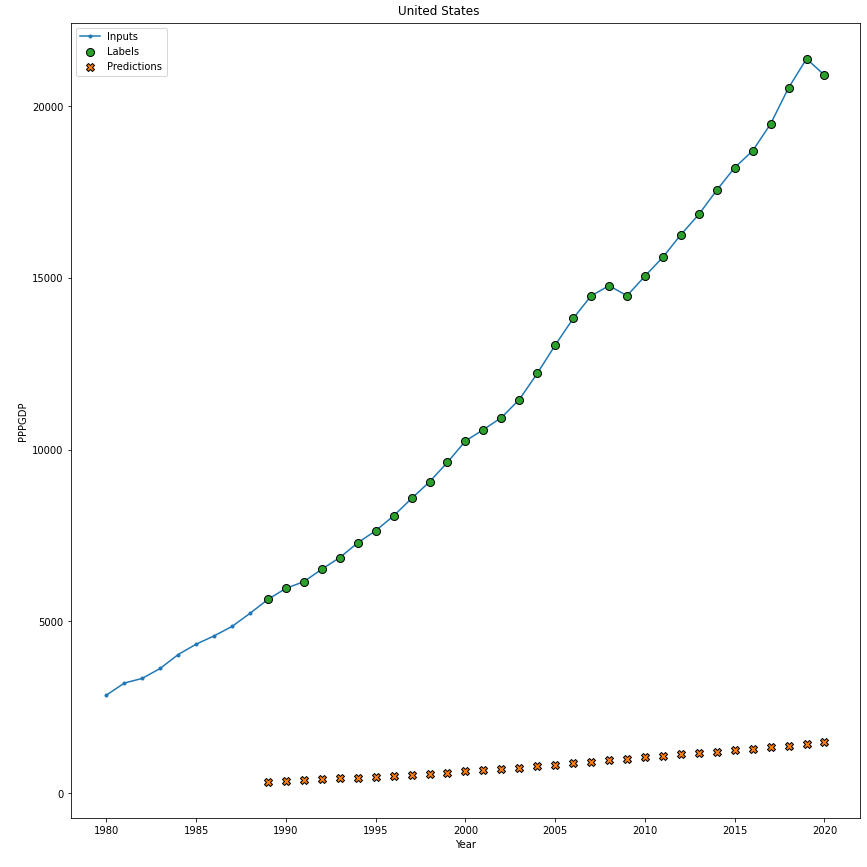

In [186]:
performance["Linear"] = linear.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Linear"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = linear.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Single Layer Perceptron

In [156]:
single = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(single, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 12s 986us/step - loss: 676945.8125 - mean_absolute_error: 152.0944 - val_loss: 20724.0098 - val_mean_absolute_error: 37.9190
Epoch 2/100
11955/11955 [==============================] - 12s 983us/step - loss: 27507.4844 - mean_absolute_error: 38.7321 - val_loss: 15361.5488 - val_mean_absolute_error: 36.2120
Epoch 3/100
11955/11955 [==============================] - 12s 992us/step - loss: 21611.5117 - mean_absolute_error: 35.0724 - val_loss: 19098.9922 - val_mean_absolute_error: 34.0978
Epoch 4/100
11955/11955 [==============================] - 12s 984us/step - loss: 18877.3984 - mean_absolute_error: 30.5853 - val_loss: 15629.2988 - val_mean_absolute_error: 29.5397
Epoch 5/100
11955/11955 [==============================] - 12s 962us/step - loss: 12709.8955 - mean_absolute_error: 26.2242 - val_loss: 4981.4609 - val_mean_absolute_error: 21.5982
Epoch 6/100
11955/11955 [==============================] - 12s 981us/step - loss: 9542.88

In [158]:
single.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 9)                 0         
                                                                 
 dense_35 (Dense)            (None, 512)               5120      
                                                                 
 dense_36 (Dense)            (None, 1)                 513       
                                                                 
 reshape_20 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 15.996286392211914


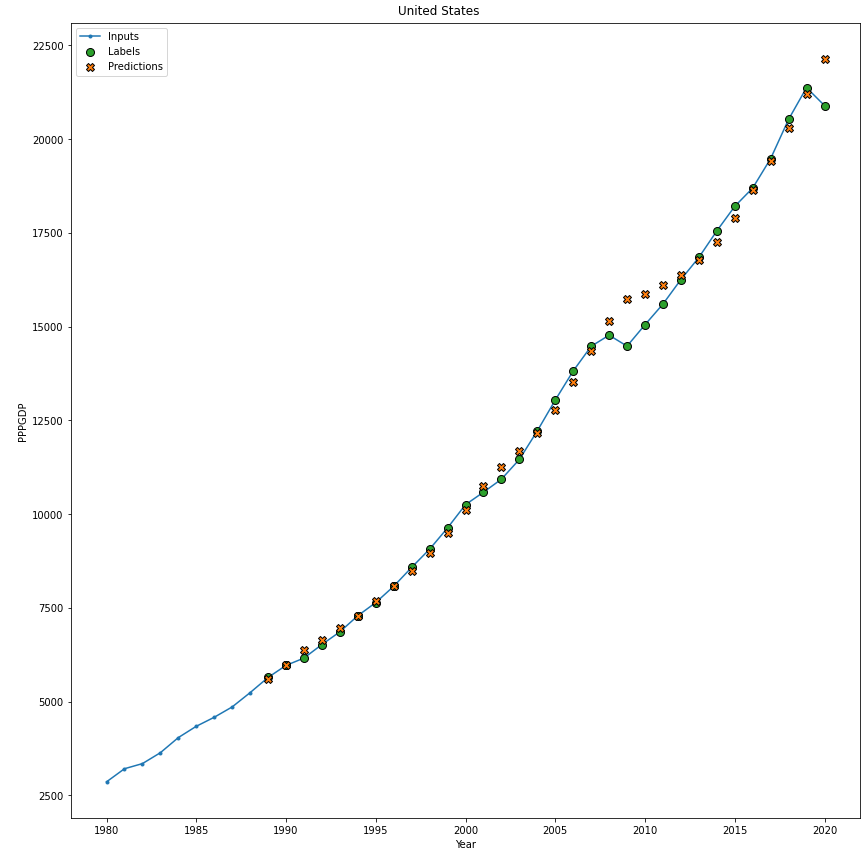

In [185]:
performance["Singlelayer Perceptron"] = single.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Singlelayer Perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = single.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Multi Layer Perceptron

In [160]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(dense, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 14s 1ms/step - loss: 167052.3594 - mean_absolute_error: 66.7170 - val_loss: 135558.9219 - val_mean_absolute_error: 89.9321
Epoch 2/100
11955/11955 [==============================] - 14s 1ms/step - loss: 35474.3906 - mean_absolute_error: 45.7454 - val_loss: 4065.2898 - val_mean_absolute_error: 19.6923
Epoch 3/100
11955/11955 [==============================] - 14s 1ms/step - loss: 27450.0039 - mean_absolute_error: 37.7881 - val_loss: 15463.8438 - val_mean_absolute_error: 29.0566
Epoch 4/100
11955/11955 [==============================] - 14s 1ms/step - loss: 29886.6465 - mean_absolute_error: 35.9637 - val_loss: 6647.9995 - val_mean_absolute_error: 21.0876
Epoch 5/100
11955/11955 [==============================] - 14s 1ms/step - loss: 28119.1973 - mean_absolute_error: 36.8014 - val_loss: 9648.7510 - val_mean_absolute_error: 26.5447
Epoch 6/100
11955/11955 [==============================] - 14s 1ms/step - loss: 21109.5137 - mean_abs

In [161]:
dense.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 9)                 0         
                                                                 
 dense_37 (Dense)            (None, 512)               5120      
                                                                 
 dense_38 (Dense)            (None, 512)               262656    
                                                                 
 dense_39 (Dense)            (None, 1)                 513       
                                                                 
 reshape_21 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 268,289
Trainable params: 268,289
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 19.735973358154297


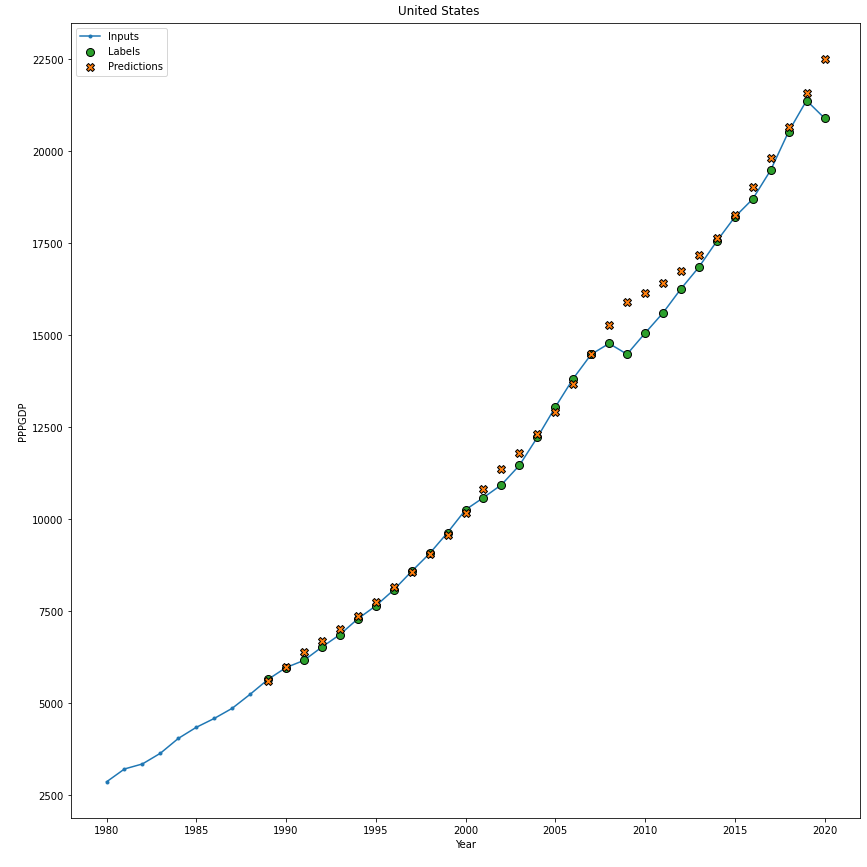

In [183]:
performance["Multilayer Perceptron"] = dense.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Multilayer Perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = dense.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network Without Pooling

In [133]:
cnnNoPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=256,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Conv1D(
            filters=128,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
        tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnNoPooling, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 28s 2ms/step - loss: 292284.9375 - mean_absolute_error: 113.5081 - val_loss: 115668.2109 - val_mean_absolute_error: 101.0816
Epoch 2/100
11955/11955 [==============================] - 28s 2ms/step - loss: 84357.9297 - mean_absolute_error: 75.2918 - val_loss: 38953.4062 - val_mean_absolute_error: 56.5622
Epoch 3/100
11955/11955 [==============================] - 28s 2ms/step - loss: 152322.5781 - mean_absolute_error: 78.8973 - val_loss: 40759.3203 - val_mean_absolute_error: 48.0491
Epoch 4/100
11955/11955 [==============================] - 28s 2ms/step - loss: 68595.8047 - mean_absolute_error: 71.7693 - val_loss: 111693.6641 - val_mean_absolute_error: 104.4463
Epoch 5/100
11955/11955 [==============================] - 28s 2ms/step - loss: 104595.4766 - mean_absolute_error: 77.6718 - val_loss: 18934.9180 - val_mean_absolute_error: 33.5836
Epoch 6/100
11955/11955 [==============================] - 28s 2ms/step - loss: 87747.0938 -

In [134]:
cnnNoPooling.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_11 (Conv1D)          (None, 7, 32)             128       
                                                                 
 conv1d_12 (Conv1D)          (None, 5, 64)             6208      
                                                                 
 conv1d_13 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 flatten_13 (Flatten)        (None, 384)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               98560     
                                                                 
 dense_27 (Dense)            (None, 1)                 257       
                                                                 
 reshape_15 (Reshape)        (None, 1, 1)            

Mean absolute error (test): 20.311906814575195


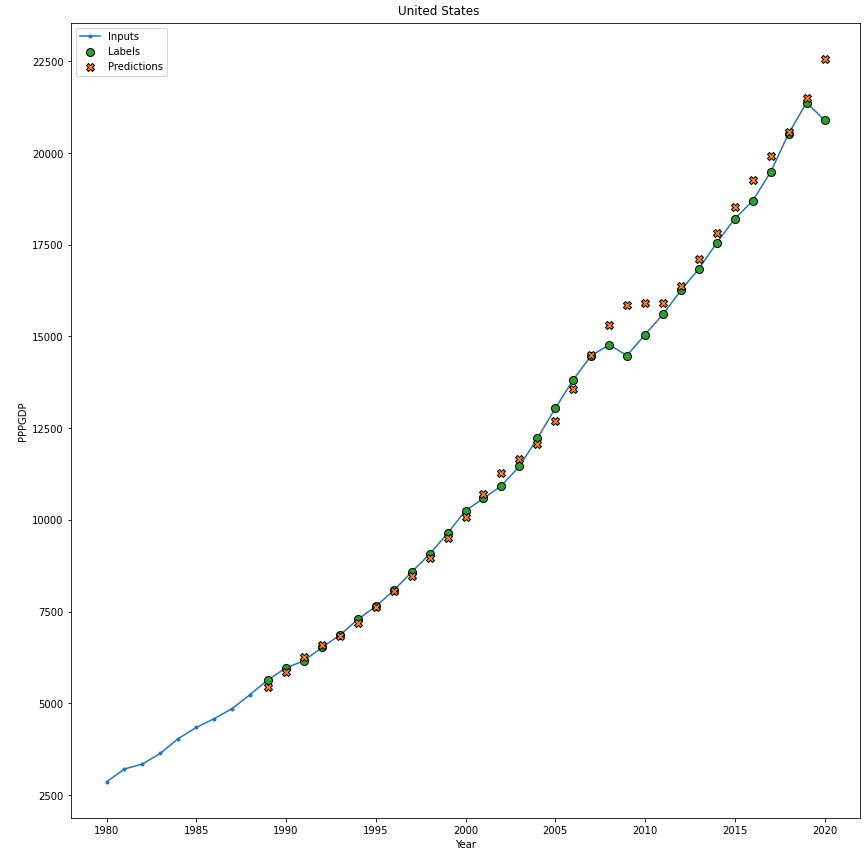

In [182]:
performance["CNN (No Pooling)"] = cnnNoPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (No Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = cnnNoPooling.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network With Pooling

In [168]:
cnnPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=512,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.AveragePooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnPooling, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 20s 2ms/step - loss: 117899.6250 - mean_absolute_error: 87.3875 - val_loss: 154184.7656 - val_mean_absolute_error: 97.6098
Epoch 2/100
11955/11955 [==============================] - 19s 2ms/step - loss: 82789.0312 - mean_absolute_error: 72.3546 - val_loss: 34352.6602 - val_mean_absolute_error: 43.4579
Epoch 3/100
11955/11955 [==============================] - 19s 2ms/step - loss: 57722.4102 - mean_absolute_error: 60.3570 - val_loss: 32663.2715 - val_mean_absolute_error: 51.0714
Epoch 4/100
11955/11955 [==============================] - 19s 2ms/step - loss: 50149.1094 - mean_absolute_error: 57.6102 - val_loss: 45611.7266 - val_mean_absolute_error: 53.6791
Epoch 5/100
11955/11955 [==============================] - 19s 2ms/step - loss: 39543.5938 - mean_absolute_error: 54.3273 - val_loss: 81322.9688 - val_mean_absolute_error: 69.3510
Epoch 6/100
11955/11955 [==============================] - 19s 2ms/step - loss: 45712.6055 - mean_

In [169]:
cnnPooling.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 7, 512)            2048      
                                                                 
 average_pooling1d_8 (Averag  (None, 3, 512)           0         
 ePooling1D)                                                     
                                                                 
 flatten_22 (Flatten)        (None, 1536)              0         
                                                                 
 dense_46 (Dense)            (None, 512)               786944    
                                                                 
 dense_47 (Dense)            (None, 1)                 513       
                                                                 
 reshape_25 (Reshape)        (None, 1, 1)              0         
                                                     

Mean absolute error (test): 50.56627655029297


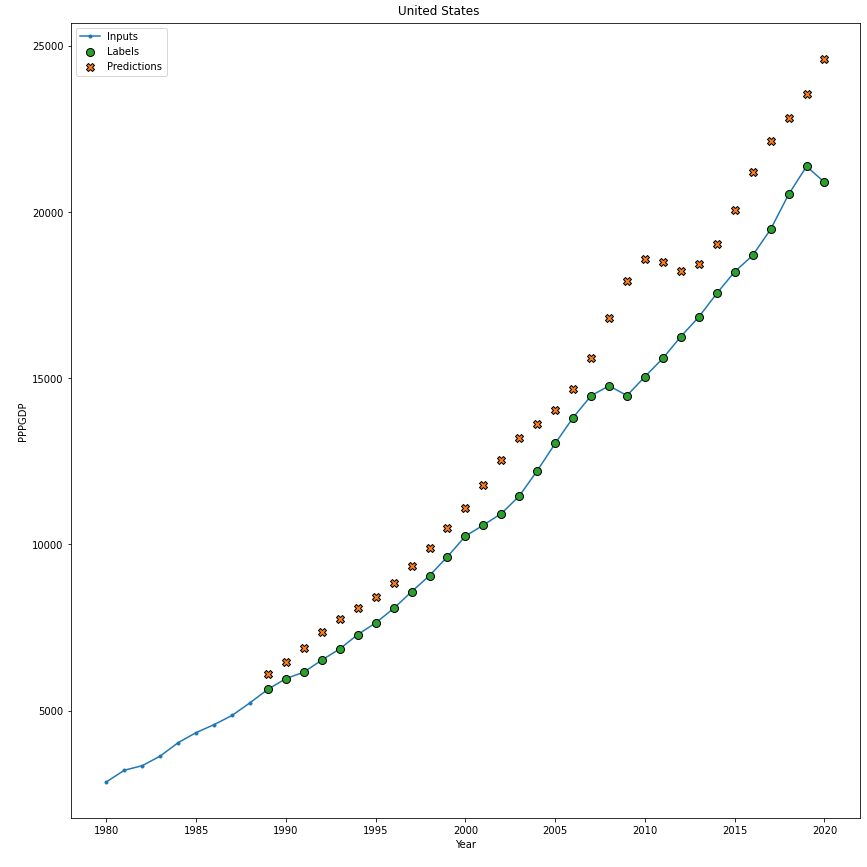

In [181]:
performance["CNN (With Pooling)"] = cnnPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (With Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = cnnPooling.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### LSTM

In [171]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(labelWidth*len(labelParams), return_sequences=False),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnPooling, trainDataset, valDataset)

Epoch 1/100
11955/11955 [==============================] - 28s 2ms/step - loss: 2268832.0000 - mean_absolute_error: 416.7444 - val_loss: 2125567.0000 - val_mean_absolute_error: 268.0982
Epoch 2/100
11955/11955 [==============================] - 27s 2ms/step - loss: 2002060.8750 - mean_absolute_error: 247.3506 - val_loss: 2384836.2500 - val_mean_absolute_error: 252.7121
Epoch 3/100
11955/11955 [==============================] - 27s 2ms/step - loss: 1709192.6250 - mean_absolute_error: 204.1369 - val_loss: 2187012.2500 - val_mean_absolute_error: 222.2413
Epoch 4/100
11955/11955 [==============================] - 27s 2ms/step - loss: 1540706.5000 - mean_absolute_error: 185.3769 - val_loss: 1535819.8750 - val_mean_absolute_error: 175.1195
Epoch 5/100
11955/11955 [==============================] - 27s 2ms/step - loss: 1252473.7500 - mean_absolute_error: 160.0573 - val_loss: 1649854.8750 - val_mean_absolute_error: 184.6306
Epoch 6/100
11955/11955 [==============================] - 26s 2ms/ste

In [172]:
lstm.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 512)               1052672   
                                                                 
 dense_48 (Dense)            (None, 1)                 513       
                                                                 
 reshape_26 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 84.0154800415039


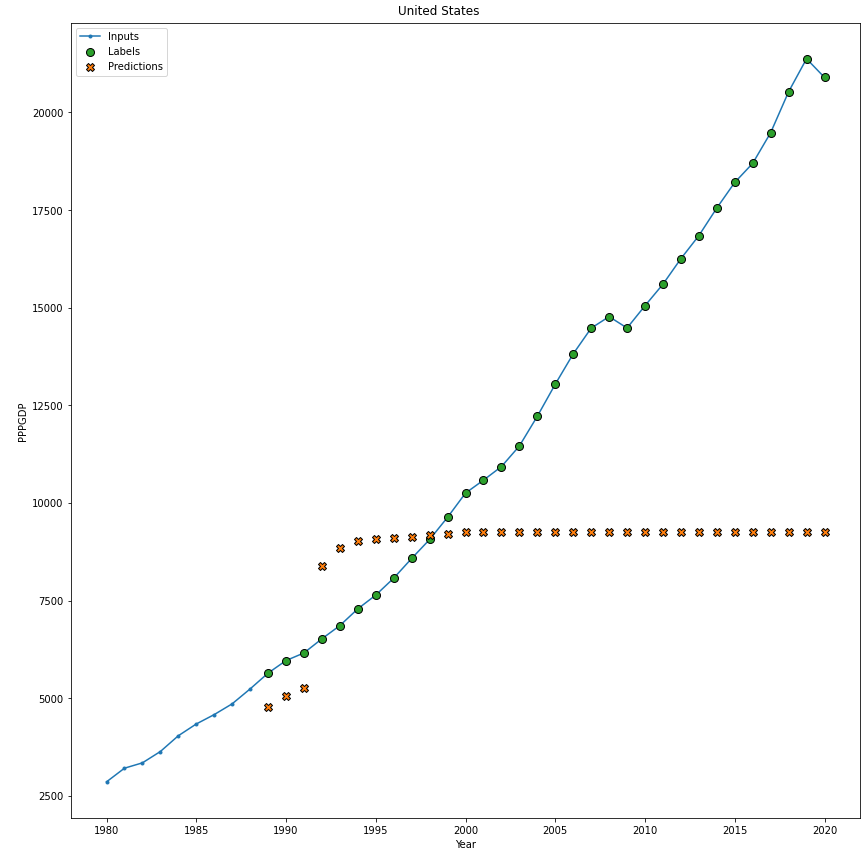

In [179]:
performance["LSTM"] = lstm.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["LSTM"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = lstm.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

## Total Performance Report

In [174]:
for key in performance:
    print(key + ": " + str(performance[key]))

linear: 421.0787353515625
multilayer perceptron: 23.417512893676758
CNN (No Pooling): 22.541515350341797
CNN (With Pooling): 42.628170013427734
LSTM: 95.48458099365234
Singlelayer Perceptron: 16.05059814453125
Multilayer Perceptron: 18.210262298583984


## Single Step / Multiple input parameters / Single Label

In [187]:
inputWidth = 9
labelWidth = 1
width = inputWidth + labelWidth
inputParams = data["WEO Subject Code"].unique()
labelParams = ["PPPGDP"]
trainSplit=0.8
valSplit=0.1
testSplit=0.1
shuffle=True

In [188]:
normalizedData = normalize(data)

timeSeries = data_to_time_series(data, width, startYear, endYear)
normalizedTimeSeries = data_to_time_series(normalizedData, width, startYear, endYear)

inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
normalizedInputs, normalizedLabels = feature_label_split_time_series(
        normalizedTimeSeries, inputWidth, labelWidth, inputParams, labelParams)

dataset = time_series_to_tf_dataset(normalizedInputs, labels, inputWidth, labelWidth)

trainDataset, valDataset, testDataset = \
        train_validate_test_split(dataset, trainSplit, valSplit, testSplit, shuffle)

## Models

In [189]:
performance = {}

### Linear

In [190]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(linear, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 8s 823us/step - loss: 3089793.2500 - mean_absolute_error: 511.8059 - val_loss: 2617773.5000 - val_mean_absolute_error: 508.5364
Epoch 2/100
8976/8976 [==============================] - 7s 817us/step - loss: 2920877.0000 - mean_absolute_error: 506.1305 - val_loss: 3219902.2500 - val_mean_absolute_error: 559.9168
Epoch 3/100
8976/8976 [==============================] - 7s 808us/step - loss: 2800066.7500 - mean_absolute_error: 505.7004 - val_loss: 3276187.0000 - val_mean_absolute_error: 561.8959
Epoch 4/100
8976/8976 [==============================] - 7s 821us/step - loss: 2825505.0000 - mean_absolute_error: 515.4570 - val_loss: 2160349.2500 - val_mean_absolute_error: 498.7086
Epoch 5/100
8976/8976 [==============================] - 7s 806us/step - loss: 2371349.0000 - mean_absolute_error: 490.0941 - val_loss: 3047380.0000 - val_mean_absolute_error: 508.1354
Epoch 6/100
8976/8976 [==============================] - 7s 794us/step - lo

In [191]:
linear.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 189)               0         
                                                                 
 dense_49 (Dense)            (None, 1)                 190       
                                                                 
 reshape_27 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 190
Trainable params: 190
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 475.5084228515625


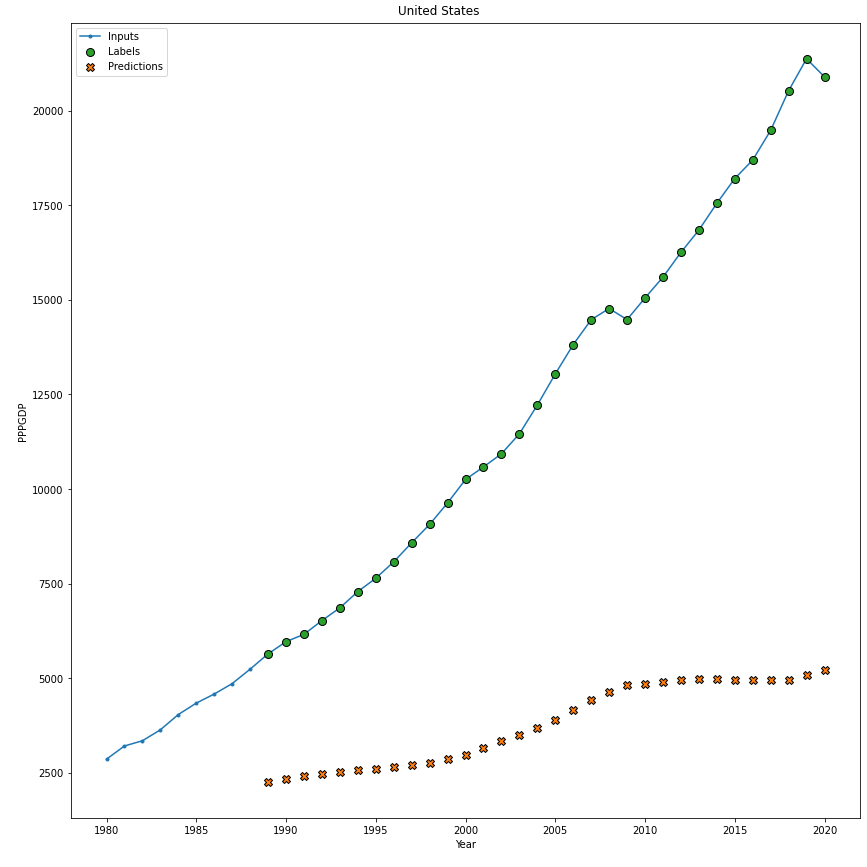

In [192]:
performance["Linear"] = linear.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Linear"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = linear.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Single Layer Perceptron

In [197]:
single = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(single, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 8s 920us/step - loss: 299159.6875 - mean_absolute_error: 153.3826 - val_loss: 77041.2891 - val_mean_absolute_error: 98.3135
Epoch 2/100
8976/8976 [==============================] - 8s 900us/step - loss: 49988.4336 - mean_absolute_error: 82.5571 - val_loss: 47377.1641 - val_mean_absolute_error: 103.3468
Epoch 3/100
8976/8976 [==============================] - 8s 914us/step - loss: 21320.6074 - mean_absolute_error: 63.9514 - val_loss: 9532.5957 - val_mean_absolute_error: 51.7950
Epoch 4/100
8976/8976 [==============================] - 8s 902us/step - loss: 12503.6357 - mean_absolute_error: 50.4505 - val_loss: 7046.3750 - val_mean_absolute_error: 45.1873
Epoch 5/100
8976/8976 [==============================] - 8s 916us/step - loss: 10872.0029 - mean_absolute_error: 46.8253 - val_loss: 4703.8037 - val_mean_absolute_error: 32.4511
Epoch 6/100
8976/8976 [==============================] - 8s 920us/step - loss: 10234.4902 - mean_absolute

In [198]:
single.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 189)               0         
                                                                 
 dense_59 (Dense)            (None, 512)               97280     
                                                                 
 dense_60 (Dense)            (None, 1)                 513       
                                                                 
 reshape_32 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 97,793
Trainable params: 97,793
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 49.23954391479492


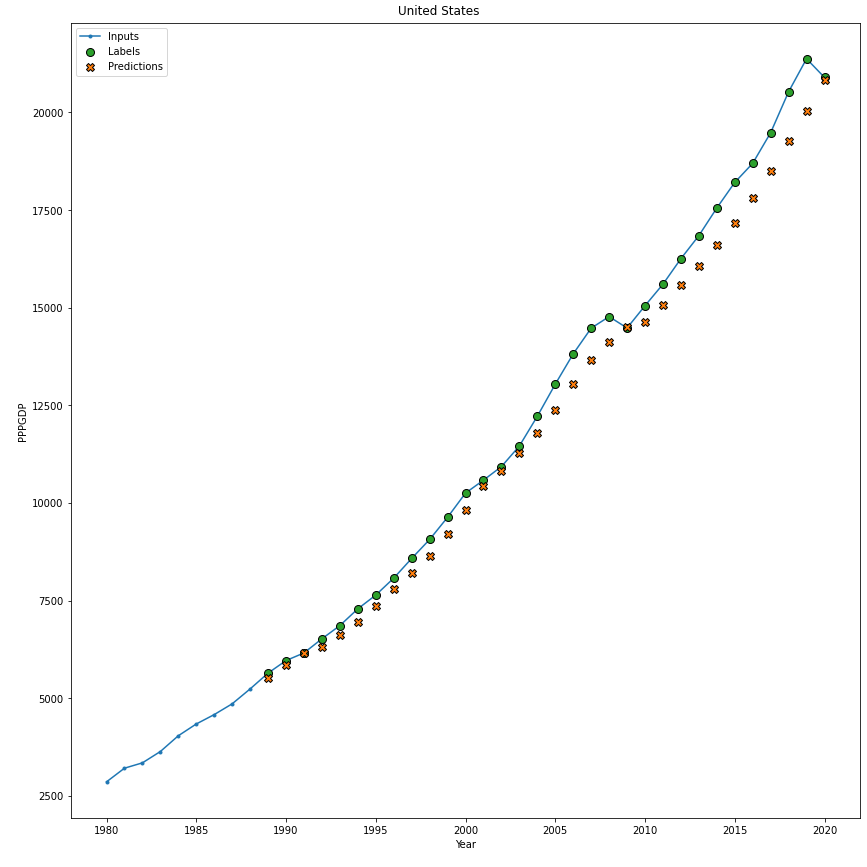

In [216]:
performance["Singlelayer Perceptron"] = single.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Singlelayer Perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = single.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Multilayer Perceptron

In [218]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(dense, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 9s 932us/step - loss: 344254.5938 - mean_absolute_error: 155.4617 - val_loss: 159723.6250 - val_mean_absolute_error: 161.3820
Epoch 2/100
8976/8976 [==============================] - 8s 930us/step - loss: 88171.1484 - mean_absolute_error: 101.4837 - val_loss: 19228.7773 - val_mean_absolute_error: 72.8852
Epoch 3/100
8976/8976 [==============================] - 8s 924us/step - loss: 49957.8516 - mean_absolute_error: 77.2842 - val_loss: 22712.0508 - val_mean_absolute_error: 64.3667
Epoch 4/100
8976/8976 [==============================] - 8s 915us/step - loss: 58755.8398 - mean_absolute_error: 73.6287 - val_loss: 14797.3506 - val_mean_absolute_error: 51.1892
Epoch 5/100
8976/8976 [==============================] - 8s 919us/step - loss: 45699.0000 - mean_absolute_error: 69.0906 - val_loss: 18754.1699 - val_mean_absolute_error: 52.1025
Epoch 6/100
8976/8976 [==============================] - 8s 925us/step - loss: 42867.3945 - mean_abs

In [219]:
dense.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 189)               0         
                                                                 
 dense_71 (Dense)            (None, 512)               97280     
                                                                 
 dense_72 (Dense)            (None, 512)               262656    
                                                                 
 dense_73 (Dense)            (None, 1)                 513       
                                                                 
 reshape_41 (Reshape)        (None, 1, 1)              0         
                                                                 
Total params: 360,449
Trainable params: 360,449
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 24.721458435058594


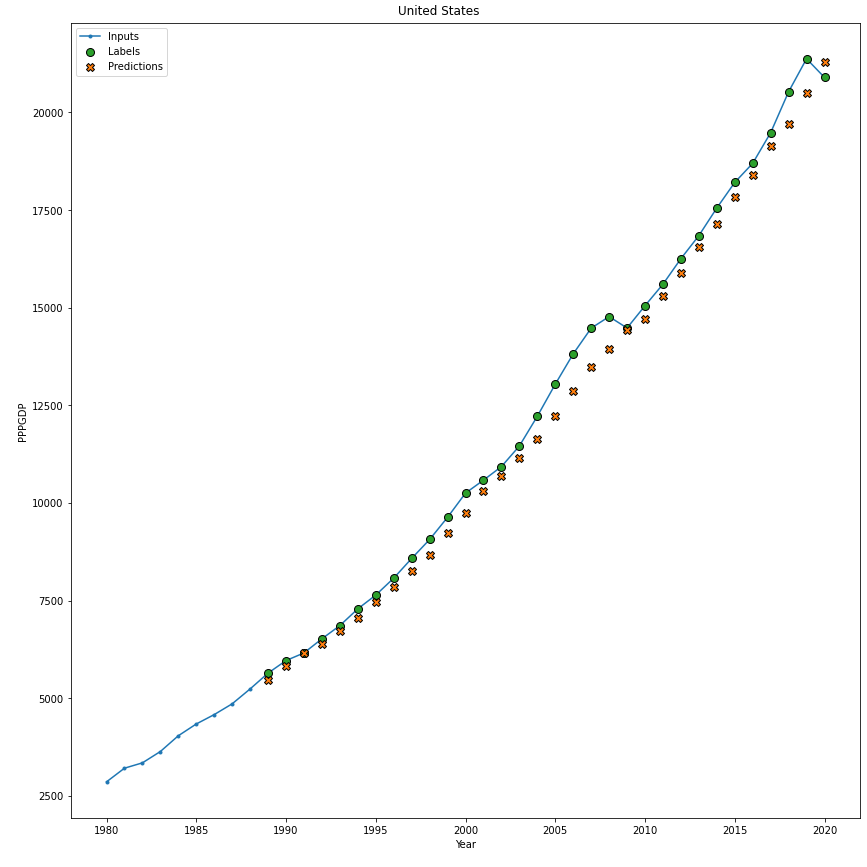

In [220]:
performance["Multilayer perceptron"] = dense.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["Multilayer perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = dense.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network Without Pooling

In [221]:
cnnNoPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=32,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
        tf.keras.layers.Conv1D(
            filters=128,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnNoPooling, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 21s 2ms/step - loss: 504048.7812 - mean_absolute_error: 175.2977 - val_loss: 162126.2500 - val_mean_absolute_error: 141.1726
Epoch 2/100
8976/8976 [==============================] - 21s 2ms/step - loss: 128237.5078 - mean_absolute_error: 99.2710 - val_loss: 20943.2754 - val_mean_absolute_error: 55.0767
Epoch 3/100
8976/8976 [==============================] - 21s 2ms/step - loss: 141420.6094 - mean_absolute_error: 113.8138 - val_loss: 34849.6719 - val_mean_absolute_error: 75.2952
Epoch 4/100
8976/8976 [==============================] - 21s 2ms/step - loss: 150467.9375 - mean_absolute_error: 100.9689 - val_loss: 21457.1094 - val_mean_absolute_error: 62.5913
Epoch 5/100
8976/8976 [==============================] - 21s 2ms/step - loss: 107496.0625 - mean_absolute_error: 80.4962 - val_loss: 17339.3887 - val_mean_absolute_error: 44.3702
Epoch 6/100
8976/8976 [==============================] - 21s 2ms/step - loss: 137067.7969 - mean_abs

In [222]:
cnnNoPooling.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_25 (Conv1D)          (None, 7, 32)             2048      
                                                                 
 conv1d_26 (Conv1D)          (None, 5, 64)             6208      
                                                                 
 conv1d_27 (Conv1D)          (None, 3, 128)            24704     
                                                                 
 flatten_34 (Flatten)        (None, 384)               0         
                                                                 
 dense_74 (Dense)            (None, 256)               98560     
                                                                 
 dense_75 (Dense)            (None, 1)                 257       
                                                                 
 reshape_42 (Reshape)        (None, 1, 1)            

Mean absolute error (test): 48.29820251464844


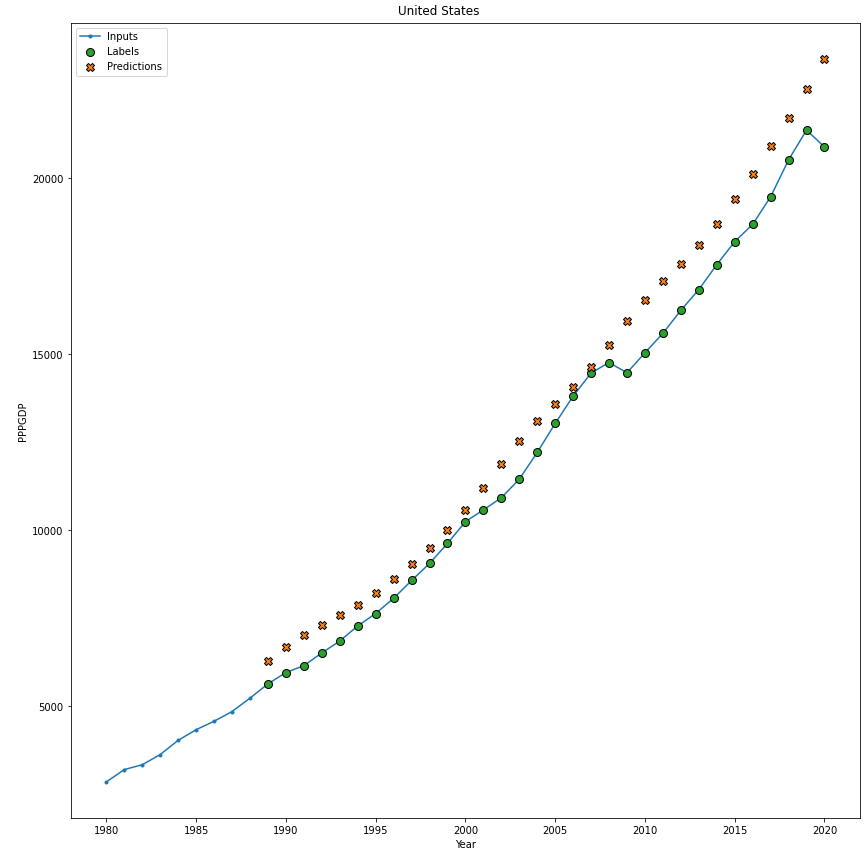

In [223]:
performance["CNN (No Pooling)"] = cnnNoPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (No Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = cnnNoPooling.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network With Pooling

In [228]:
cnnPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=256,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.AveragePooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnPooling, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 15s 2ms/step - loss: 221693.7344 - mean_absolute_error: 147.9404 - val_loss: 63189.1406 - val_mean_absolute_error: 89.9063
Epoch 2/100
8976/8976 [==============================] - 15s 2ms/step - loss: 66418.4844 - mean_absolute_error: 93.8185 - val_loss: 17352.8809 - val_mean_absolute_error: 59.4965
Epoch 3/100
8976/8976 [==============================] - 14s 2ms/step - loss: 53688.5547 - mean_absolute_error: 77.9488 - val_loss: 109232.0078 - val_mean_absolute_error: 110.3512
Epoch 4/100
8976/8976 [==============================] - 14s 2ms/step - loss: 42433.9727 - mean_absolute_error: 72.0894 - val_loss: 26754.6133 - val_mean_absolute_error: 72.9713
Epoch 5/100
8976/8976 [==============================] - 14s 2ms/step - loss: 40286.0156 - mean_absolute_error: 66.1984 - val_loss: 33041.3750 - val_mean_absolute_error: 67.3224
Epoch 6/100
8976/8976 [==============================] - 15s 2ms/step - loss: 36161.1250 - mean_absolute_e

In [229]:
cnnPooling.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 7, 256)            16384     
                                                                 
 average_pooling1d_11 (Avera  (None, 3, 256)           0         
 gePooling1D)                                                    
                                                                 
 flatten_36 (Flatten)        (None, 768)               0         
                                                                 
 dense_78 (Dense)            (None, 256)               196864    
                                                                 
 dense_79 (Dense)            (None, 1)                 257       
                                                                 
 reshape_45 (Reshape)        (None, 1, 1)              0         
                                                     

Mean absolute error (test): 45.54634094238281


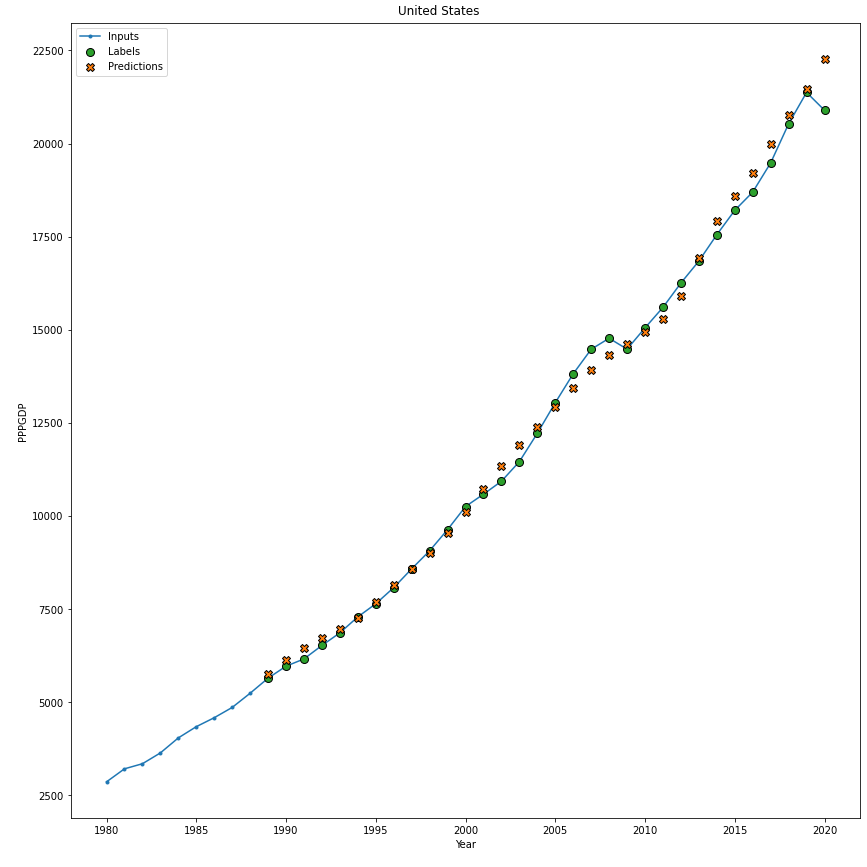

In [230]:
performance["CNN (With Pooling)"] = cnnPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (With Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = cnnPooling.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### LSTM

In [231]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(labelWidth*len(labelParams), return_sequences=False),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(lstm, trainDataset, valDataset)

Epoch 1/100
8976/8976 [==============================] - 63s 7ms/step - loss: 3244229.2500 - mean_absolute_error: 516.3637 - val_loss: 3244254.0000 - val_mean_absolute_error: 500.7219
Epoch 2/100
8976/8976 [==============================] - 59s 7ms/step - loss: 3188928.0000 - mean_absolute_error: 517.8794 - val_loss: 2718640.2500 - val_mean_absolute_error: 456.7713
Epoch 3/100
8976/8976 [==============================] - 59s 7ms/step - loss: 3211476.0000 - mean_absolute_error: 521.6570 - val_loss: 2939634.0000 - val_mean_absolute_error: 509.7364
Epoch 4/100
8976/8976 [==============================] - 59s 7ms/step - loss: 3241821.0000 - mean_absolute_error: 523.2510 - val_loss: 3258447.7500 - val_mean_absolute_error: 528.7410
Epoch 5/100
8976/8976 [==============================] - 59s 7ms/step - loss: 3219903.7500 - mean_absolute_error: 520.1419 - val_loss: 2710316.2500 - val_mean_absolute_error: 519.9234
Epoch 6/100
8976/8976 [==============================] - 59s 7ms/step - loss: 31

In [232]:
lstm.summary()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 9, 64)             22016     
                                                                 
 lstm_35 (LSTM)              (None, 9, 128)            98816     
                                                                 
 lstm_36 (LSTM)              (None, 9, 256)            394240    
                                                                 
 lstm_37 (LSTM)              (None, 9, 128)            197120    
                                                                 
 lstm_38 (LSTM)              (None, 9, 64)             49408     
                                                                 
 lstm_39 (LSTM)              (None, 1)                 264       
                                                                 
 reshape_46 (Reshape)        (None, 1, 1)            

Mean absolute error (test): 559.2528686523438


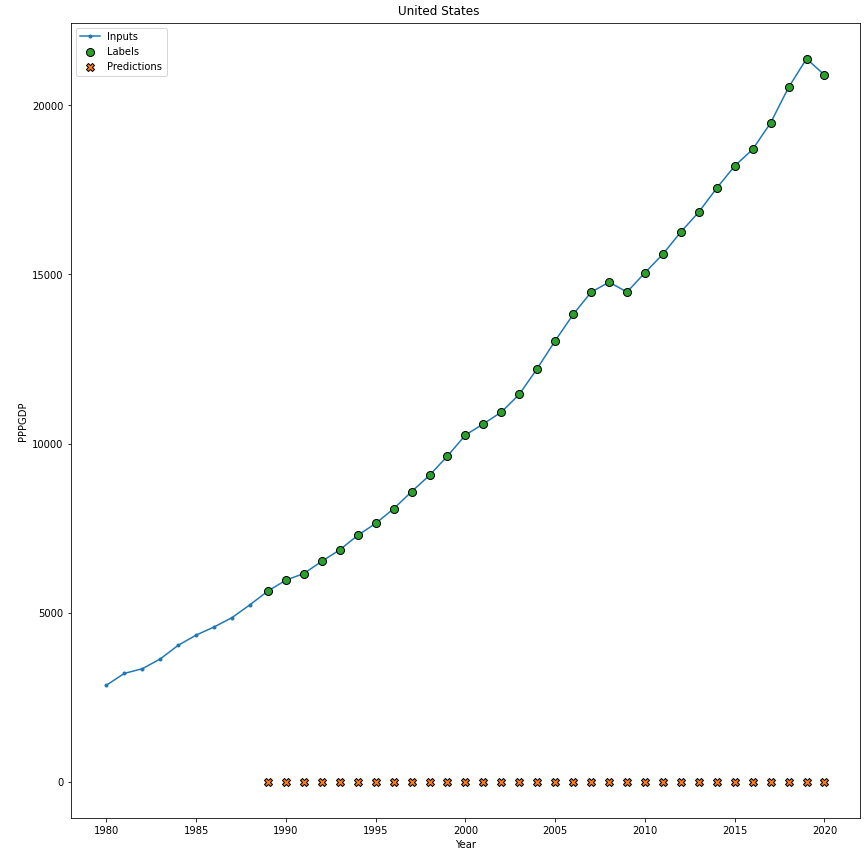

In [233]:
performance["LSTM"] = lstm.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["LSTM"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions = lstm.predict(usDataset)
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

## Total Performance Report

In [234]:
for key in performance:
    print(key + ": " + str(performance[key]))

Linear: 475.5084228515625
Singlelayer Perceptron: 49.23954391479492
multilayer perceptron: 25.81125831604004
CNN (No Pooling): 48.29820251464844
CNN (With Pooling): 45.54634094238281
Multilayer perceptron: 24.721458435058594
LSTM: 559.2528686523438


## Multistep / Multilabel on GDP

In [75]:
performance = {}

In [76]:
inputWidth = 9
labelWidth = 3
width = inputWidth + labelWidth
inputParams = data["WEO Subject Code"].unique()
labelParams = ["PPPGDP"] 
trainSplit=0.8
valSplit=0.1
testSplit=0.1
shuffle=True

normalizedData = normalize(data)

timeSeries = data_to_time_series(data, width, startYear, endYear)
normalizedTimeSeries = data_to_time_series(normalizedData, width, startYear, endYear)

inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
normalizedInputs, normalizedLabels = feature_label_split_time_series(
        normalizedTimeSeries, inputWidth, labelWidth, inputParams, labelParams)

dataset = time_series_to_tf_dataset(normalizedInputs, labels, inputWidth, labelWidth)

trainDataset, valDataset, testDataset = \
        train_validate_test_split(dataset, trainSplit, valSplit, testSplit, shuffle)

### Linear

In [77]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(linear, trainDataset, valDataset)

Epoch 1/100
8169/8169 [==============================] - 6s 776us/step - loss: 2837200.7500 - mean_absolute_error: 509.1316 - val_loss: 2420232.2500 - val_mean_absolute_error: 497.6844
Epoch 2/100
8169/8169 [==============================] - 6s 769us/step - loss: 2666461.2500 - mean_absolute_error: 498.6308 - val_loss: 2843996.0000 - val_mean_absolute_error: 487.8072
Epoch 3/100
8169/8169 [==============================] - 6s 766us/step - loss: 2641156.2500 - mean_absolute_error: 493.9890 - val_loss: 2737275.5000 - val_mean_absolute_error: 514.6666
Epoch 4/100
8169/8169 [==============================] - 6s 772us/step - loss: 2432606.5000 - mean_absolute_error: 496.2191 - val_loss: 2059742.8750 - val_mean_absolute_error: 503.5065
Epoch 5/100
8169/8169 [==============================] - 6s 768us/step - loss: 2496093.0000 - mean_absolute_error: 500.6657 - val_loss: 2802811.5000 - val_mean_absolute_error: 518.1441
Epoch 6/100
8169/8169 [==============================] - 6s 759us/step - lo

In [78]:
linear.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 189)               0         
                                                                 
 dense_20 (Dense)            (None, 3)                 570       
                                                                 
 reshape_11 (Reshape)        (None, 3, 1)              0         
                                                                 
Total params: 570
Trainable params: 570
Non-trainable params: 0
_________________________________________________________________


Mean absolute error (test): 544.8238525390625
30


ValueError: x and y must have same first dimension, but have shapes (3,) and (1, 3, 1)

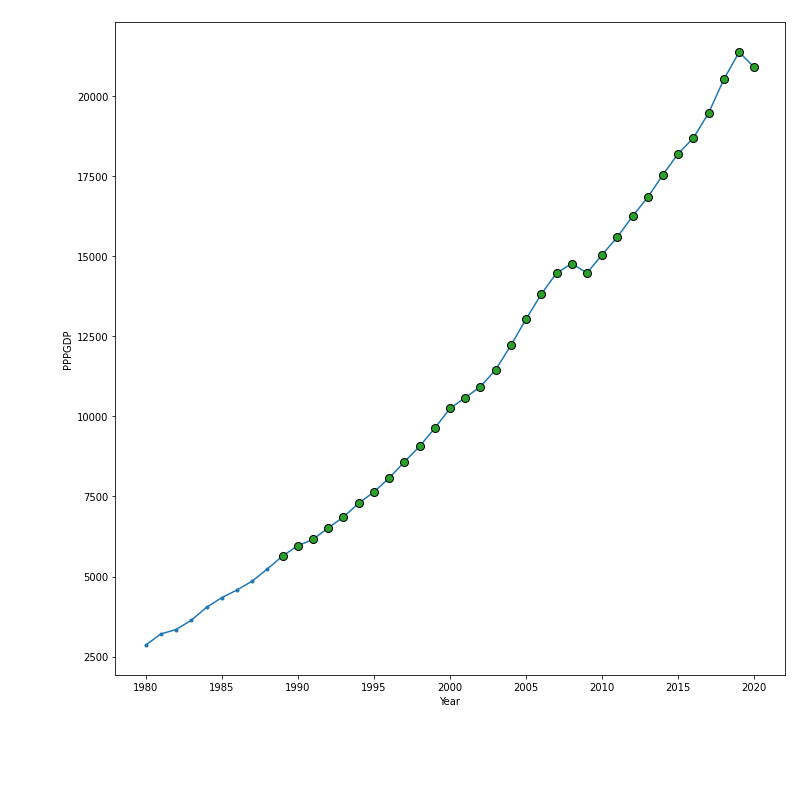

In [91]:
performance["linear"] = linear.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["linear"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (linear(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Multilayer Perceptron

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(dense, trainDataset, valDataset)

In [ ]:
dense.summary()

In [ ]:
performance["multilayer perceptron"] = dense.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["multilayer perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (dense(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network Without Pooling

In [ ]:
cnnNoPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=32,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
        tf.keras.layers.Conv1D(
            filters=128,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnNoPooling, trainDataset, valDataset)

In [ ]:
cnnNoPooling.summary()

In [ ]:
performance["CNN (No Pooling)"] = cnnNoPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (No Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (cnnNoPooling(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network With Pooling

In [ ]:
cnnPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=256,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.AveragePooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnPooling, trainDataset, valDataset)

In [ ]:
cnnPooling.summary()

In [ ]:
performance["CNN (With Pooling)"] = cnnPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (With Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (cnnPooling(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### LSTM

In [ ]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(lstm, trainDataset, valDataset)

In [ ]:
lstm.summary()

In [ ]:
performance["LSTM"] = lstm.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["LSTM"]))

In [ ]:
print(performance)

## Multiple input paramMultistep on percent annual inflation

In [ ]:
performance = {}

In [ ]:
inputWidth = 9
labelWidth = 3
width = inputWidth + labelWidth
inputParams = data["WEO Subject Code"].unique()
labelParams = ["PCPIPCH"]
trainSplit=0.8
valSplit=0.1
testSplit=0.1
shuffle=True

normalizedData = normalize(data)

timeSeries = data_to_time_series(data, width, startYear, endYear)
normalizedTimeSeries = data_to_time_series(normalizedData, width, startYear, endYear)

inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
normalizedInputs, normalizedLabels = feature_label_split_time_series(
        normalizedTimeSeries, inputWidth, labelWidth, inputParams, labelParams)

dataset = time_series_to_tf_dataset(normalizedInputs, labels, inputWidth, labelWidth)

trainDataset, valDataset, testDataset = \
        train_validate_test_split(dataset, trainSplit, valSplit, testSplit, shuffle)

### Linear

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(linear, trainDataset, valDataset)

In [ ]:
linear.summary()

In [ ]:
performance["linear"] = linear.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["linear"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (linear(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)


### Multilayer Perceptron

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(dense, trainDataset, valDataset)

In [ ]:
dense.summary()

In [ ]:
performance["multilayer perceptron"] = dense.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["multilayer perceptron"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (dense(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network Without Pooling

In [ ]:
cnnNoPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=32,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Conv1D(
            filters=64,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
        tf.keras.layers.Conv1D(
            filters=128,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnNoPooling, trainDataset, valDataset)

In [ ]:
cnnNoPooling.summary()

In [ ]:
performance["CNN (No Pooling)"] = cnnNoPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (No Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (cnnNoPooling(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### Convolutional Neural Network With Pooling

In [ ]:
cnnPooling = tf.keras.Sequential([
    tf.keras.layers.Conv1D(
            filters=256,
            kernel_size=(3,),
            activation='relu',
            input_shape=(inputWidth,len(inputParams))),
    tf.keras.layers.AveragePooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(cnnPooling, trainDataset, valDataset)

In [ ]:
cnnPooling.summary()

In [ ]:
performance["CNN (With Pooling)"] = cnnPooling.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["CNN (With Pooling)"]))

timeSeries = data_to_time_series(normalizedData[(data["Country"] == "United States")], width, startYear, endYear)
inputs, labels = feature_label_split_time_series(
        timeSeries, inputWidth, labelWidth, inputParams, labelParams)
usDataset = time_series_to_tf_dataset(inputs, labels, inputWidth, labelWidth).batch(1)
predictions=np.ndarray((len(usDataset), labelWidth, len(labelParams)))
for i, tensor in enumerate(iter(usDataset)):
    predictions[i] = (cnnPooling(tensor[0]).numpy())
plot(data, inputWidth=inputWidth, labelWidth=labelWidth, predictions=predictions, countries=["United States"], codes=labelParams)

### LSTM

In [ ]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=False),
    tf.keras.layers.Dense(units=labelWidth*len(labelParams)),
    tf.keras.layers.Reshape([labelWidth, -1])
])

history = compile_and_fit(lstm, trainDataset, valDataset)

In [ ]:
lstm.summary()

In [ ]:
performance["LSTM"] = lstm.evaluate(testDataset, verbose=0)[1]
print("Mean absolute error (test): " + str(performance["LSTM"]))

In [ ]:
print(performance)